In [1]:
from pathlib import Path

In [3]:
from datasets import load_dataset

dataset = load_dataset("hynky/czech_news_dataset", split="train")

AttributeError: partially initialized module 'datasets' has no attribute 'utils' (most likely due to a circular import)

In [7]:
# plot the distribution of the dates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df = pd.DataFrame(dataset, columns=["date"])
df["date"] = pd.to_datetime(df["date"])

In [2]:
import scipy.sparse
tfidf_path = Path("dataset/base/test_tfidf.npz")
tfidf = scipy.sparse.load_npz(tfidf_path)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/base/test_tfidf.npz'

In [18]:
import numpy as np
x = np.random.rand(100, 100)
y = np.random.randint(0, 2, 100)

In [15]:
scores = ['precision', 'recall']

In [22]:
from sklearn.linear_model import LogisticRegression
search =GridSearchCV(LogisticRegression(), {"C": [1,2]}, cv=3, refit="recall", scoring=scores, return_train_score=True)

In [23]:
search.fit(x, y)

GridSearchCV(cv=3, estimator=LogisticRegression(), param_grid={'C': [1, 2]},
             refit='recall', return_train_score=True,
             scoring=['precision', 'recall'])

In [34]:
{s: score_fc(search, x, y) for s, score_fc in search.scorer_.items()}

{'precision': 1.0, 'recall': 0.9777777777777777}

In [35]:
import pandas as pd

In [38]:
dat =pd.DataFrame(search.cv_results_)

In [57]:
isinstance(1, (int, float))

True

In [55]:
for index, row in dat.iterrows():
    print(row.to_dict())

[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'int'>, <class 'dict'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'int'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'int'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'int'>, <class 'dict'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'int'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'int'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


In [3]:
from datasets import load_dataset
test = load_dataset("../final_dataset/dataset.py", split="test").select(range(1000))

Found cached dataset dataset (/home/kydliceh/.cache/huggingface/datasets/dataset/default/0.0.0/dd40f907db796b1c96c399ea8c9ec6f99ebe75363e9a0f0f63f6a15c6f03423f)


In [4]:
trans.transform(test)

IndexError: list index out of range

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from utils.utils import noneToMinus, removeMinus, PickledTransform, MemoryCache
import numpy as np

In [5]:
from sacremoses import MosesTokenizer
tokenizer = MosesTokenizer('cs')
tokenizer.tokenize()

['None']

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def report_stats(y):
    uniq, counts = np.unique(y, return_counts=True)
    max_i = np.argmax(counts)
    print(f"Length: {len(y)}")
    print(f"Length Unique values: {len(uniq)}")
    print(uniq)
    print(f"Baseline with max class {uniq[max_i]}: {counts[max_i] / len(y)}")

def plot_distribution(y):
    un, counts = np.unique(y, return_counts=True)
    plt.bar(un, counts)
    plt.show()

In [9]:
import pickle


base_folder = Path("Baseline") / "pickled_models"
token_folder = base_folder / "tokenized"

In [7]:
from sacremoses import MosesTokenizer
from tqdm import tqdm

# PRETOKENIZATION AS IT TAKES LONG TIME AND IS REUSED

tokenizer = MosesTokenizer(lang="cz")

def preprocess(s):
    lowered = s.lower()
    return lowered


train_content_tokenized = [tokenizer.tokenize(preprocess(cont)) for cont in tqdm(train_dataset["content"])]
eval_content_tokenized = [tokenizer.tokenize(preprocess(cont)) for cont in tqdm(eval_dataset["content"])]
test_content_tokenized = [tokenizer.tokenize(preprocess(cont)) for cont in tqdm(test_dataset["content"])]


NameError: name 'train_dataset' is not defined

In [10]:
pickle.dump(train_content_tokenized, (token_folder / "train_content_tokenized.pkl").open("wb"))
pickle.dump(eval_content_tokenized, (token_folder / "eval_content_tokenized.pkl").open("wb"))
pickle.dump(test_content_tokenized, (token_folder / "test_content_tokenized.pkl").open("wb"))

In [48]:
train_content_tokenized = pickle.load((token_folder / "train_content_tokenized.pkl").open("rb"))
eval_content_tokenized = pickle.load((token_folder / "eval_content_tokenized.pkl").open("rb"))
test_content_tokenized = pickle.load((token_folder / "test_content_tokenized.pkl").open("rb"))

In [46]:
from pathlib import Path
from stop_words import get_stop_words
stop_words = get_stop_words('czech')
def dummy(x):
    return x

vectorizer_params = {
    "ngram_range": [(1, 2)],
}

# Dont' use any tokenizer as the input is pretokenized to save time
vectorizer = TfidfVectorizer(stop_words=stop_words, preprocessor=dummy ,tokenizer=dummy)

In [1]:
from datasets import load_dataset
v1_train = load_dataset("hynky/czech_news_dataset", split="train")
v1_test = load_dataset("hynky/czech_news_dataset", split="test")
v1_dev = load_dataset("hynky/czech_news_dataset", split="validation")



Found cached dataset parquet (/home/kydliceh/.cache/huggingface/datasets/hynky___parquet/hynky--czech_news_dataset-7e1b6d781523c0de/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/kydliceh/.cache/huggingface/datasets/hynky___parquet/hynky--czech_news_dataset-7e1b6d781523c0de/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/kydliceh/.cache/huggingface/datasets/hynky___parquet/hynky--czech_news_dataset-7e1b6d781523c0de/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [ ]:
# get first dates

<AxesSubplot: >

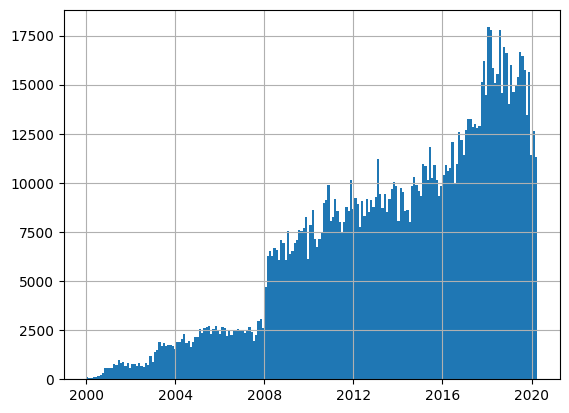

In [13]:
# plot dates historgram of train
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = v1_train.to_pandas()
df.date = pd.to_datetime(df.date)
df.date.hist(bins=200)

In [23]:
df[df.server == 7].date.min()

NaT

In [24]:
# Get first dates
train_v1.features

NameError: name 'v1' is not defined